In [1]:
# Source: https://github.com/vassagoP/segment-anything/blob/main/notebooks/predictor_example.ipynb
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

from nibabel.viewers import OrthoSlicer3D

from segment_anything import SamAutomaticMaskGenerator
import supervision as sv

import torchmetrics
from torchmetrics.functional import dice

In [2]:
# Utils
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

uint8
(512, 512, 3)


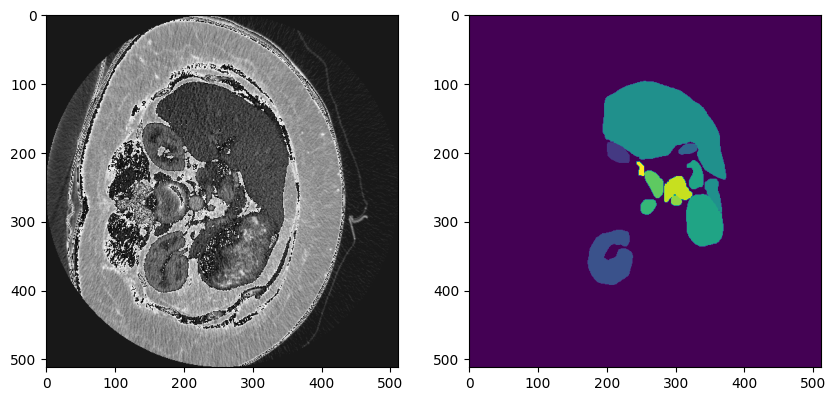

In [3]:
# Read data
import nibabel as nib
import imageio
import os

img_path = './data/RawData/Training/img/'
img_filenames = os.listdir(img_path)
image_nib = nib.load(img_path + img_filenames[0])
image = image_nib.get_fdata().astype(np.uint8)
image0 = image[:,:,100]
image0 = np.stack((image0,)*3, axis=-1)
print(image0.dtype)
print(image0.shape)

label_path = './data/RawData/Training/label/'
label_filenames = os.listdir(label_path)
label_nib = nib.load(label_path + label_filenames[0])
label = label_nib.get_fdata().astype(np.uint8)
label0 = label[:,:,100]
# label0 = np.stack((label0,)*3, axis=-1)


plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image0)
plt.subplot(1, 2, 2)
plt.imshow(label0)
plt.show()


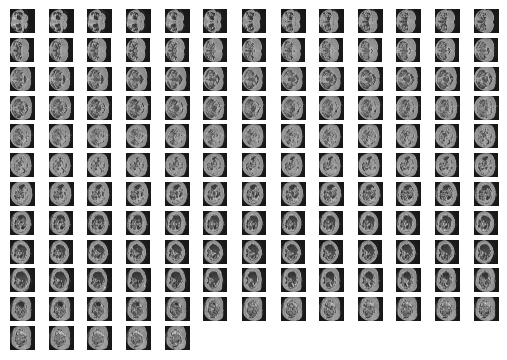

In [4]:
# 3D viewer
shape0 = image.shape
# OrthoSlicer3D(image).show()

x = int((shape0[2]) ** 0.5) + 1
num = 1
for i in range(0, shape0[2], 1):
    img_arr = image[:,:,i]
    plt.subplot(x, x, num)
    plt.imshow(img_arr, cmap='gray')
    plt.axis('off')
    num += 1

plt.show()

In [5]:
# SAM model
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image0)

/home/vectorzhao/anaconda3/envs/sam/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


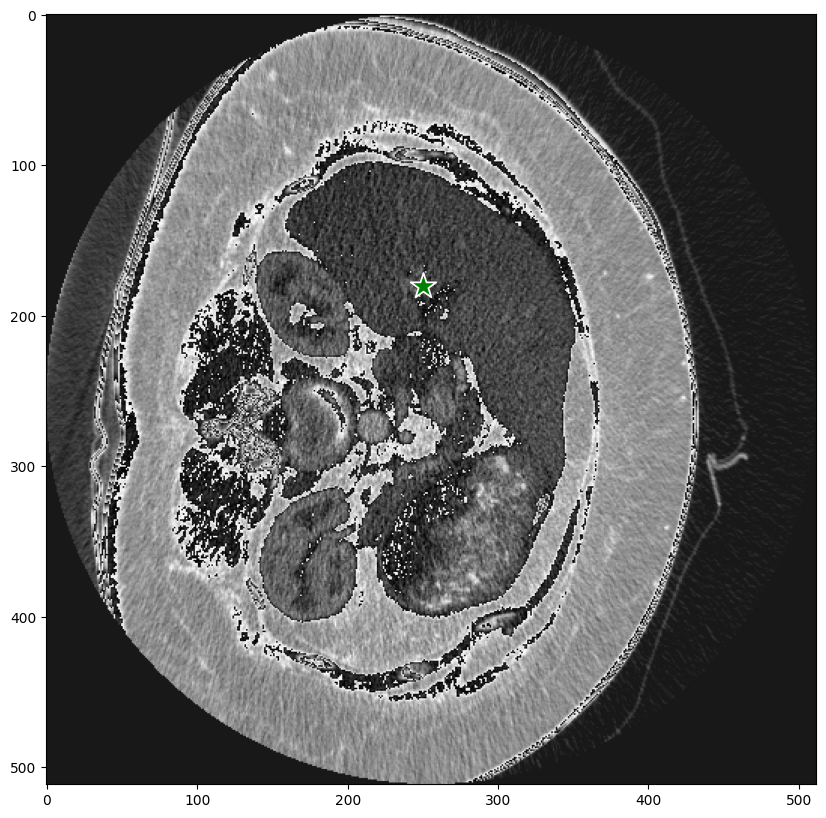

SAM: point mask results


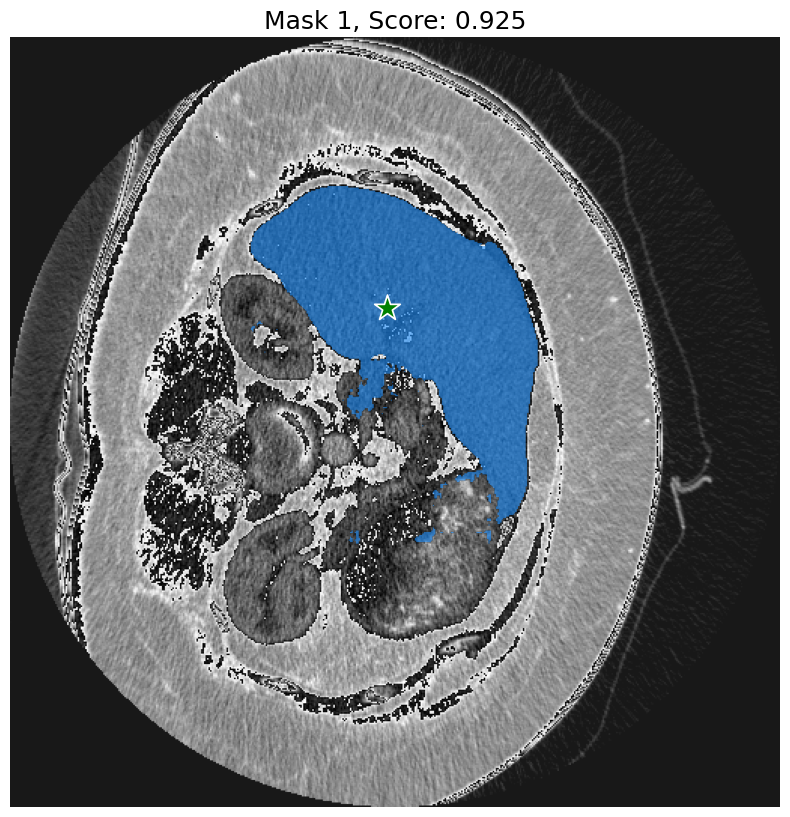

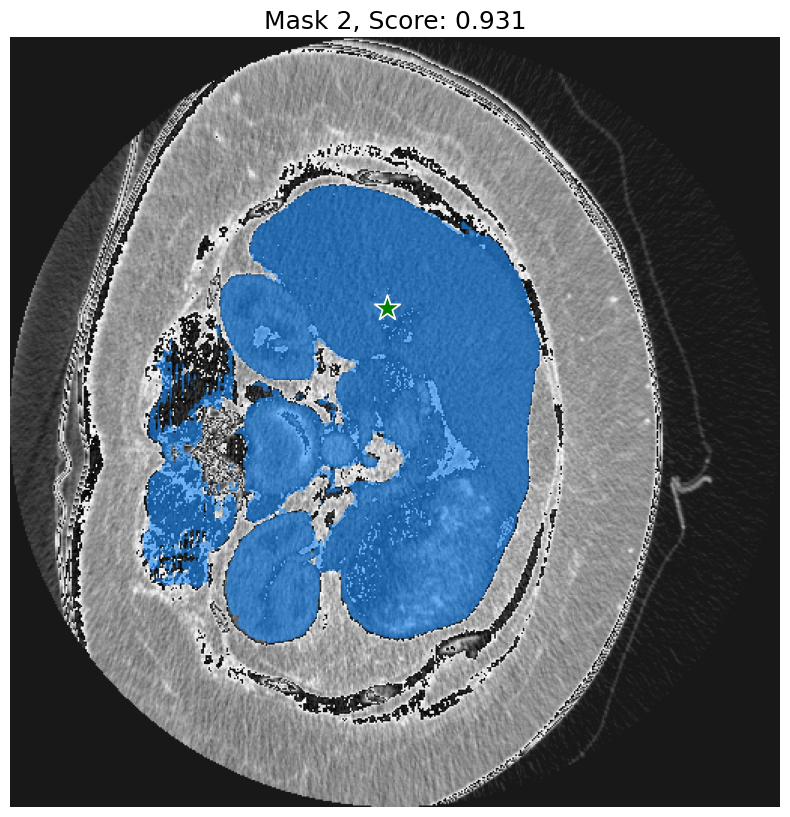

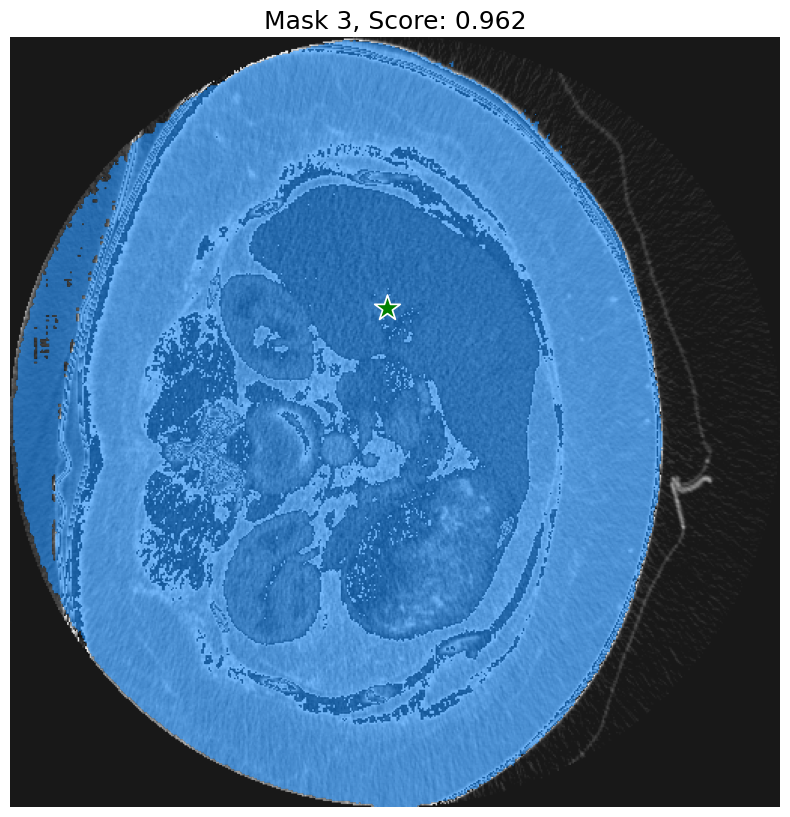

In [6]:
# SAM: point mask, using Predictor
input_point = np.array([[250, 180]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image0)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

# SAM: point mask results
print("SAM: point mask results")
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image0)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [7]:
# Test dice for image0
input_point = np.array([[250, 180]])
input_label = np.array([1])
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
'''
plt.figure(figsize=(10,10))
plt.imshow(image0)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()
'''
label0, masks = torch.tensor(label0), torch.tensor(masks)
print(label0.shape, masks.shape)
d = dice(masks, label0)
print("Dice: ", d)

torch.Size([512, 512]) torch.Size([1, 512, 512])
Dice:  tensor(0.8317)


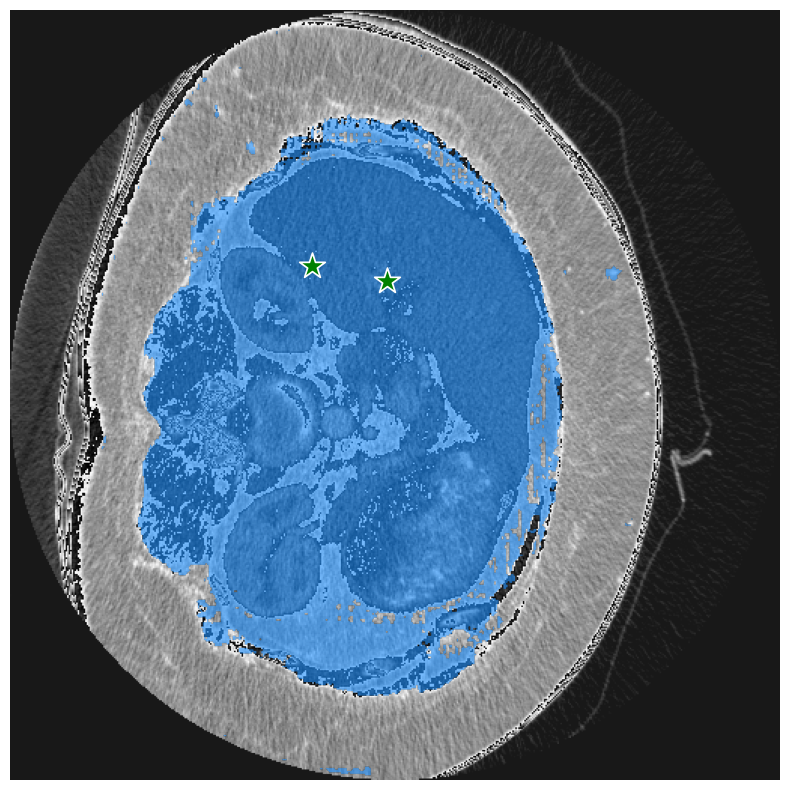

In [8]:
# SAM: multi-point mask, using Predictor
input_point = np.array([[250, 180], [200, 170]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

plt.figure(figsize=(10,10))
plt.imshow(image0)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 


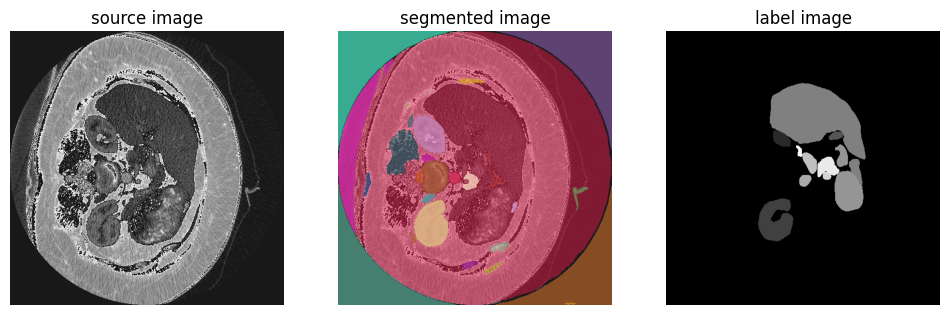

In [9]:
# SAM: mask generation, using AutoMaskGenerator
mask_generator = SamAutomaticMaskGenerator(sam)

sam_result = mask_generator.generate(image0)
# print(sam_result)

mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image0.copy(), detections=detections)

sv.plot_images_grid(
    images=[image0, annotated_image, label0],
    grid_size=(1, 3),
    titles=['source image', 'segmented image', 'label image']
)